https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95?fbclid=IwAR3WB8cL1Qk7icQgbjaj8rw3iGGjo8M4wRIiEAb3zZC8anTow9uV4IvxTcU
https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Vehicles/bm4k-52h4?fbclid=IwAR17Ba6CEepQQTKNt5qIB-p2QQmSWS8HrTei1kygpXaWkKQeutg3IPGVjuo
https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Person/f55k-p6yu?fbclid=IwAR1k9QCQYOXIHXw061OGsCp0kmBlFOrSl310kjpSIpp2CYdgVb6odkgNm20

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shapefile as shp
import urllib, gdal, subprocess
import json
import requests
import folium
import datetime
import warnings
import random
warnings.filterwarnings("ignore")

sns.set(style='darkgrid', palette='muted', color_codes=True)
#sns.mpl.rc('figure', figsize=(10,6))
# Set a plot style for nice plots.

# Magic command useful jupyter notebook
%matplotlib inline



#Set font size
plt.rcParams.update({'font.size':16})

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [70]:
%%time
filename = "Motor_Vehicle_Collisions_-_Crashes.csv"
# filename = 'crash_clean.csv'
filename2 = "Motor_Vehicle_Collisions_-_Person.csv"
# filename = "crash_clean.csv"
p = 1 # 1% of the lines
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
df = pd.read_csv(
         filename,
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p)

# df2 = pd.read_csv(
#          filename2,
#          header=0, 
#          skiprows=lambda i: i>0 and random.random() > p)

Wall time: 22.2 s


In [71]:
df = df.loc[(df.LONGITUDE >-74.5) & (df.LONGITUDE < -73) & (df.LATITUDE <41) & (df.LATITUDE > 40.5)]
# df2 = df2.loc[(df2['PERSON_AGE']>0) & (df2['PERSON_AGE'] <100 )]

In [72]:
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'])
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

In [69]:
df.groupby('NUMBER OF PERSONS INJURED').size()

NUMBER OF PERSONS INJURED
0.0     108357
1.0      20625
2.0       5248
3.0       1832
4.0        641
5.0        233
6.0        106
7.0         42
8.0         19
9.0          8
10.0         5
11.0         1
12.0         3
13.0         1
16.0         2
18.0         1
32.0         1
dtype: int64

In [25]:
# X = df[['CRASH TIME','NUMBER OF PERSONS INJURED']]
X = df[['BOROUGH','CRASH TIME','CRASH DATE','CONTRIBUTING FACTOR VEHICLE 1','NUMBER OF PERSONS INJURED']]
print('Shape before drop {}'.format(X.shape))
X = X.dropna()
print('Shape after drop {}'.format(X.shape))

Shape before drop (137132, 5)
Shape after drop (98392, 5)


In [26]:
X['CRASH TIME'] = df['CRASH TIME'].dt.hour
X['CRASH DATE'] = df['CRASH DATE'].dt.dayofweek

In [27]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
X['CONTRIBUTING FACTOR VEHICLE 1'] = labelencoder.fit_transform(X['CONTRIBUTING FACTOR VEHICLE 1'])

In [28]:
X['NUMBER OF PERSONS INJURED']

8          0.0
23         0.0
28         0.0
33         1.0
40         0.0
          ... 
1672263    0.0
1672292    0.0
1672319    1.0
1672322    0.0
1672333    0.0
Name: NUMBER OF PERSONS INJURED, Length: 98392, dtype: float64

In [29]:
X['NUMBER OF PERSONS INJURED'] = X['NUMBER OF PERSONS INJURED'].apply(lambda x: 1 if x > 0 else x)

In [30]:
mi = min(X.groupby('NUMBER OF PERSONS INJURED').size())
ma = max(X.groupby('NUMBER OF PERSONS INJURED').size())
X = X.drop(X[X['NUMBER OF PERSONS INJURED']==0].sample(frac=(1-(mi/ma))).index)

In [31]:
X.groupby(['NUMBER OF PERSONS INJURED']).size()

NUMBER OF PERSONS INJURED
0.0    20318
1.0    20318
dtype: int64

In [32]:
y = X['NUMBER OF PERSONS INJURED']
X = X[['BOROUGH','CRASH TIME','CRASH DATE','CONTRIBUTING FACTOR VEHICLE 1']]

In [33]:
X = pd.get_dummies(X,columns=['BOROUGH','CRASH DATE'])
X

CRASH TIME  CONTRIBUTING FACTOR VEHICLE 1  BOROUGH_BRONX  \
28                8                             17              0   
33               21                             10              0   
70               18                             54              0   
186              22                             54              0   
262              12                             40              0   
...             ...                            ...            ...   
1672190          16                             54              0   
1672218          17                             18              0   
1672223          16                             54              0   
1672263          20                             31              0   
1672319          19                             54              0   

         BOROUGH_BROOKLYN  BOROUGH_MANHATTAN  BOROUGH_QUEENS  CRASH DATE_0  \
28                      0                  0               1             0   
33                      0                  0               1             1   
70                      0                  0               1             0   
186                     0                  0               1             0   
262                     0                  0               1             1   
...                   ...                ...             ...           ...   
1672190                 0                  0               1             0   
1672218                 0                  0               1             0   
1672223                 0                  0               1             0   
1672263                 0                  0               1             0   
1672319                 0                  0               1             0   

         CRASH DATE_1  CRASH DATE_2  CRASH DATE_3  CRASH DATE_4  CRASH DATE_5  \
28                  0             1             0             0             0   
33                  0             0             0             0             0   
70                  0             0             0             0             1   
186                 1             0             0             0             0   
262                 0             0             0             0             0   
...               ...           ...           ...           ...           ...   
1672190             0             0             0             1             0   
1672218             0             1             0             0             0   
1672223             0             0             0             0             1   
1672263             0             0             0             0             1   
1672319             0             0             1             0             0   

         CRASH DATE_6  
28                  0  
33                  0  
70                  0  
186                 0  
262                 0  
...               ...  
1672190             0  
1672218             0  
1672223             0  
1672263             0  
1672319             0  

[40636 rows x 13 columns]

In [34]:
header = X.columns.values.tolist()

In [35]:
X = X.values
y = y.values

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [36]:
from sklearn.decomposition import PCA

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [38]:
# pca = PCA(n_components=10)
# pca.fit(X_train)
# X_train = pca.transform(X_train)
# pca.fit(X_test)
# X_test = pca.transform(X_test)
# print(pca.explained_variance_ratio_)

In [39]:
clf = LogisticRegression()
clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
prediction = clf.predict(X_test)

In [41]:
accuracy_score(y_test,prediction)

0.522296793437733

Feature 0: CRASH TIME, SCORE 0.04
Feature 1: CONTRIBUTING FACTOR VEHICLE 1, SCORE -0.06
Feature 2: BOROUGH_BRONX, SCORE -0.01
Feature 3: BOROUGH_BROOKLYN, SCORE 0.02
Feature 4: BOROUGH_MANHATTAN, SCORE 0.05
Feature 5: BOROUGH_QUEENS, SCORE -0.00
Feature 6: CRASH DATE_0, SCORE 0.01
Feature 7: CRASH DATE_1, SCORE -0.01
Feature 8: CRASH DATE_2, SCORE -0.01
Feature 9: CRASH DATE_3, SCORE 0.02
Feature 10: CRASH DATE_4, SCORE -0.02
Feature 11: CRASH DATE_5, SCORE -0.00
Feature 12: CRASH DATE_6, SCORE 0.00


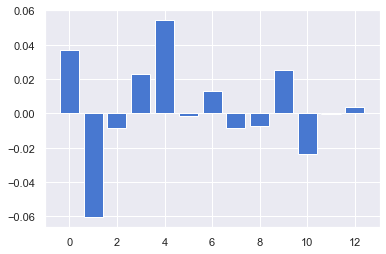

In [42]:
importance = clf.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature {}: {}, SCORE {:.2f}'.format(i,header[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [44]:
clf = RandomForestClassifier(n_estimators = 50)
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)
accuracy_score(y_test,prediction)

0.5483221476510067

In [45]:
(prediction==1).sum()

6209

In [46]:
(prediction==0).sum()

7201

Feature 0: CRASH TIME, SCORE 0.39
Feature 1: CONTRIBUTING FACTOR VEHICLE 1, SCORE 0.56
Feature 2: BOROUGH_BRONX, SCORE 0.00
Feature 3: BOROUGH_BROOKLYN, SCORE 0.00
Feature 4: BOROUGH_MANHATTAN, SCORE 0.00
Feature 5: BOROUGH_QUEENS, SCORE 0.00
Feature 6: CRASH DATE_0, SCORE 0.01
Feature 7: CRASH DATE_1, SCORE 0.01
Feature 8: CRASH DATE_2, SCORE 0.01
Feature 9: CRASH DATE_3, SCORE 0.01
Feature 10: CRASH DATE_4, SCORE 0.01
Feature 11: CRASH DATE_5, SCORE 0.01
Feature 12: CRASH DATE_6, SCORE 0.01


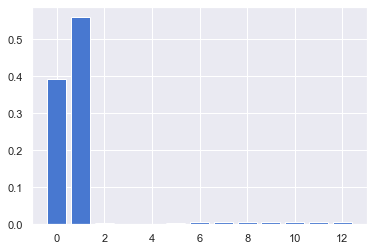

In [47]:
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature {}: {}, SCORE {:.2f}'.format(i,header[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [134]:
lat,long =(40.78343, -73.96625)

In [135]:
lat

40.78343

In [136]:
XX = df.loc[(df.LONGITUDE >long-0.05) & (df.LONGITUDE < long +0.05) & (df.LATITUDE <lat +0.05) & (df.LATITUDE > lat-0.05)]

In [137]:
lis = (['Failure to Yield Right-of-Way','Following Too Closely','Backing Unsafely'])
XX = XX[XX['CONTRIBUTING FACTOR VEHICLE 1'].isin(lis)]

In [138]:
X = XX[['LATITUDE','LONGITUDE','CONTRIBUTING FACTOR VEHICLE 1']]
X = X.dropna()
X = X.values

In [139]:
X

array([[40.749171999999994, -73.967026, 'Following Too Closely'],
       [40.77592, -73.95317, 'Following Too Closely'],
       [40.802753, -73.93358, 'Failure to Yield Right-of-Way'],
       ...,
       [40.766504299999994, -73.99417340000001, 'Backing Unsafely'],
       [40.7902528, -73.9456349, 'Failure to Yield Right-of-Way'],
       [40.733761799999996, -73.9374216, 'Backing Unsafely']],
      dtype=object)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X[:,:2],X[:,-1] , test_size=0.33, random_state=42)


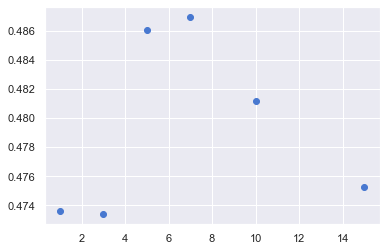

In [142]:
n = [1,3,5,7,10,15]
accuracy = []
for i in n:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))

plt.plot(n,accuracy,'o')

### KNN Grid

# test = [[y[11],x[11]]]
# df_test = pd.DataFrame(test)
# if knn.predict(df_test) == 'DRUG/NARCOTIC':
#     print('yes')



In [110]:
StartX = XX['LATITUDE'].min()
EndX = XX['LATITUDE'].max()

StartY = XX['LONGITUDE'].min()
EndY = XX['LONGITUDE'].max()

y = np.linspace(StartX,EndX,50)
x = np.linspace(StartY,EndY,50)

print(StartX,EndX)
print(StartY,EndY)

40.733433000000005 40.83335170000001
-74.0102151 -73.91626


In [143]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

mapz = folium.Map([40.730610, -73.935242], zoom_start=11)

for i in range(len(x)):
    for j in range(len(y)):
        data = [[y[j],x[i]]]
        df_test = pd.DataFrame(data)
        predict = knn.predict(df_test)

        if predict == lis[0]:
            folium.CircleMarker([y[j], x[i]],fill=True, # Set fill to True
                                        fill_color='blue',
                                        color = 'blue',
                                       radius = 0.5
                ).add_to(mapz)         
                                
        elif predict == lis[1]:
            folium.CircleMarker([y[j], x[i]],fill=True, # Set fill to True
                                        fill_color='green',
                                        color = 'green',
                                        radius = 0.5
                                
                ).add_to(mapz)
        elif predict == lis[2]:
            folium.CircleMarker([y[j], x[i]],fill=True, # Set fill to True
                                        fill_color='red',
                                        color = 'red',
                                        radius = 0.5
                               ).add_to(mapz)
# Display map
mapz

In [133]:
lis

['Failure to Yield Right-of-Way', 'Following Too Closely', 'Backing Unsafely']

In [132]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
predict = knn.predict(X_test)

mapz = folium.Map([40.730610, -73.935242], zoom_start=11)

for i in range(len(predict)):
    
    if predict[i] == lis[0]:
        folium.CircleMarker([X_test[i,0], X_test[i,1]],fill=True, # Set fill to True
                                    fill_color='blue',
                                    color = 'blue',
                                   radius = 2
            ).add_to(mapz)         

    elif predict[i] == lis[1]:
        folium.CircleMarker([X_test[i,0], X_test[i,1]],fill=True, # Set fill to True
                                    fill_color='green',
                                    color = 'green',
                                    radius = 2

            ).add_to(mapz)
    elif predict[i] == lis[2]:
        folium.CircleMarker([X_test[i,0], X_test[i,1]],fill=True, # Set fill to True
                                    fill_color='red',
                                    color = 'red',
                                    radius = 2
                           ).add_to(mapz)
# Display map
mapz

In [169]:
df.shape

(1469326, 29)

In [170]:
df = df.loc[df['CRASH DATE'] < '31/12/2017']

In [173]:
df.shape

(1021722, 29)

In [ ]:
(df_pros['Date'] > '15/06/2016') & (df_pros['Date'] <= '15/07/2016')